In [1]:
# import needed libraries
import os
import shutil
import numpy as np
import pandas as pd

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders 

# المسار الأصلي للبيانات 
data = "/kaggle/input/fall-elderly-people-detection"

# المجلد الذي سيتم تخزين البيانات المقسمة فيه
data_after_split = "dataset"

# تقسيم البيانات بنسبة 70% تدريب، 15% تحقق، 15% اختبار
splitfolders.ratio(data, output=data_after_split, seed=42, ratio=(0.7, 0.15, 0.15))

print("Data split into Train / Validation / Test successfully!")

Copying files: 2585 files [00:22, 112.58 files/s]

Data split into Train / Validation / Test successfully!


In [4]:
# التحقق من عدد الصور في كل مجموعة
for subset in ["train", "val", "test"]:
    print(f"{subset.upper()} DATA:")
    for class_name in os.listdir(os.path.join(data_after_split, subset)):
        class_folder = os.path.join(data_after_split, subset, class_name)
        if os.path.isdir(class_folder):
            print(f"{class_name}: {len(os.listdir(class_folder))} image")

TRAIN DATA:
Not Fall: 1210 image
Fall: 599 image
VAL DATA:
Not Fall: 259 image
Fall: 128 image
TEST DATA:
Not Fall: 260 image
Fall: 129 image


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "dataset/train",
    target_size=(612, 408),
    batch_size=32,
    class_mode="binary"
)

val_generator = datagen.flow_from_directory(
    "dataset/val",
    target_size=(612, 408),
    batch_size=32,
    class_mode="binary"
)

test_generator = datagen.flow_from_directory(
    "dataset/test",
    target_size=(612, 408),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

print("Data uploaded successfully with Augmentation for training")

Found 1809 images belonging to 2 classes.
Found 387 images belonging to 2 classes.
Found 389 images belonging to 2 classes.
Data uploaded successfully with Augmentation for training


In [6]:
import tensorflow as tf
from tensorflow import keras

# تحميل النموذج الأساسي بدون الطبقات العلوية
base_model = keras.applications.MobileNetV2(
    input_shape=(612, 408, 3),
    include_top=False,  # إزالة الطبقات الأصلية الخاصة بـ 1000 تصنيف
    weights="imagenet"
)

# تجميد أوزان الطبقات الأساسية لمنع تعديلها أثناء التدريب الأولي
base_model.trainable = False

# بناء الطبقات الجديدة الخاصة بمهمة التصنيف
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),  # تقليل الأبعاد
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  # تصنيف ثنائي (fall / not fall)
])

# تجميع النموذج
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

<ipython-input-6-038fe0dd4ba2>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 20, 13, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,177,025 (12.12 MB)

 Trainable params: 919,041 (3.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(train_generator, epochs=40, validation_data=val_generator, verbose=1)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 561ms/step - accuracy: 0.6794 - loss: 0.6075 - val_accuracy: 0.8734 - val_loss: 0.3505
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 394ms/step - accuracy: 0.8701 - loss: 0.3379 - val_accuracy: 0.8915 - val_loss: 0.2463
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.9142 - loss: 0.2233 - val_accuracy: 0.9096 - val_loss: 0.2080
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.9172 - loss: 0.2021 - val_accuracy: 0.9121 - val_loss: 0.1915
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.9357 - loss: 0.1764 - val_accuracy: 0.9251 - val_loss: 0.1796
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9427 - loss: 0.1372 - val_accuracy: 0.9225 - val_loss: 0.1707
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.9530 - loss: 0.1260 - val_accuracy: 0.9251 - val_loss: 0.1732
Epoch 8/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.9470 - loss: 0.1290 - val_accuracy: 0.922

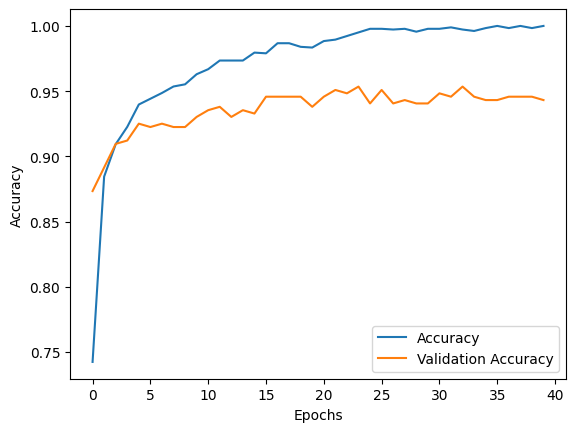

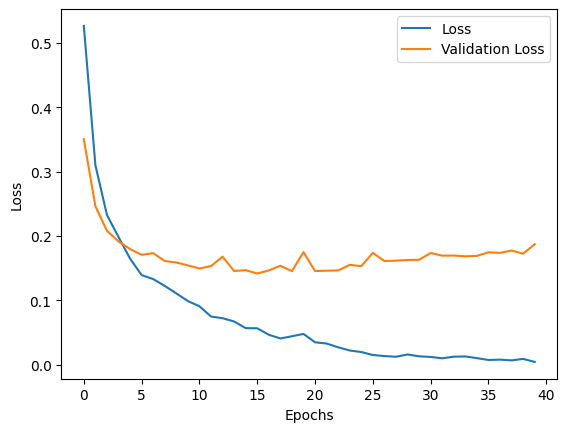

In [8]:
import matplotlib.pyplot as plt

# رسم الدقة والخسارة
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")

Final Training Accuracy: 100.00%
Final Validation Accuracy: 94.32%


In [10]:
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.9702 - loss: 0.0969
Test Accuracy: 97.17%


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step


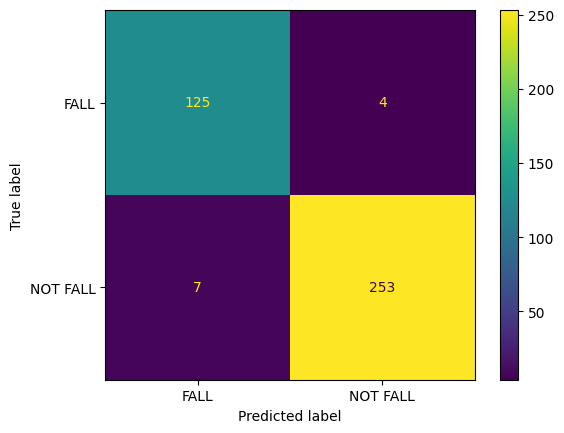

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(test_generator)
y_pred = (pred > 0.5).astype("int32") 
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FALL", "NOT FALL"])
disp.plot()

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_true, y_pred, target_names=["FALL", "NOT FALL"]))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_true, y_pred)*100))

              precision    recall  f1-score   support

        FALL       0.95      0.97      0.96       129
    NOT FALL       0.98      0.97      0.98       260

    accuracy                           0.97       389
   macro avg       0.97      0.97      0.97       389
weighted avg       0.97      0.97      0.97       389

Accuracy of the Model: 97.2%


In [15]:
print(test_generator.class_indices)

{'Fall': 0, 'Not Fall': 1}


In [16]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # ضغط الأوزان إلى 16-bit

tflite_model = converter.convert()

with open("model_float16.tflite", "wb") as f:
    f.write(tflite_model)

print("The model has been saved in a small size without losing resolution. ✅")

Saved artifact at '/tmp/tmpxi1kydc2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 612, 408, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132872694084560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694178112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694180224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694173536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694175824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694183744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694184096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694185504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694181984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872694183392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1328726941856

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# 📌 تحميل النموذج المضغوط (Float16 TFLite)
interpreter = tf.lite.Interpreter(model_path="model_float16.tflite")
interpreter.allocate_tensors()

# 📌 الحصول على تفاصيل المدخلات والمخرجات
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 📌 تحميل الصورة وإعدادها بنفس تنسيق النموذج
img_path = "/kaggle/input/testing-2/download (1).jpeg"
img = image.load_img(img_path, target_size=(612, 408))  # تأكد من أن الحجم متوافق مع النموذج
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # إضافة بعد الدُفعة (batch)
img_array = img_array.astype(np.float32) / 255.0  # التأكد من نوع البيانات

# 📌 وضع البيانات في المفسر (Interpreter)
interpreter.set_tensor(input_details[0]['index'], img_array)

# 📌 تشغيل التنبؤ
interpreter.invoke()

# 📌 استخراج النتيجة
prediction = interpreter.get_tensor(output_details[0]['index'])
predicted_class = "NOT FALL" if prediction > 0.5 else "FALL"

# 📌 طباعة النتيجة
print(f"Predicted Class: {predicted_class} ({prediction})")

Predicted Class: FALL ([[0.00012853]])
